## IMPORTS

In [1]:
from skimage import filters
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib
from skimage import data, img_as_float
from skimage import exposure
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, Dropout, GlobalMaxPooling2D,MaxPool2D, \
Flatten, Dense, Activation, BatchNormalization, MaxPooling2D,LeakyReLU
import random
from tensorflow.keras import regularizers

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import sys, os

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# %cd /content/drive/My\ Drive/

In [4]:
# !unzip ProjectDataset.zip

## Global stuff

In [55]:
def extractImages(data):
    normalImages = []
    Labels = []
    for i in data:
        if i.endswith('.png'):
            img=cv2.imread(i)
            img1=cv2.resize(img, (50,50))
            normalImages.append(img1)
            Labels.append(i[-5])
    Labels=np.array(Labels)
    normalImages = np.array(normalImages)
    return normalImages,Labels


def minorPreprocess(normalImages):
    rescaled = []
    hist_equalised = []
    adapt_equalised = []
    grayed = []
    for i in range(len(normalImages)):
        img = normalImages[i]
        grayed.append(img)
        rescaled.append(exposure.rescale_intensity(img, in_range=(2,98)))
        hist_equalised.append(exposure.equalize_hist(img))
        adapt_equalised.append(exposure.equalize_adapthist(img, clip_limit=0.03))
    return rescaled,hist_equalised,adapt_equalised,grayed


def makeGenerator():    
    datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=True,  
        samplewise_center=False, 
        featurewise_std_normalization=True, 
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=180, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        shear_range = 0.2, 
        horizontal_flip=True,  
        vertical_flip=True,
        zoom_range=0.2)
    return datagen


def createModel(bias):   
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(50, 50, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid',bias_initializer=bias)
    ])
    return model



def createResnetTransferModel(inputShape,bias):
  resnet_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape =inputShape)
  resnet_model.trainable = False
  # set_trainable = False
  # for layer in resnet_model.layers:
  #     if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
  #         set_trainable = True
  #     if set_trainable:
  #         layer.trainable = True
  #     else:
  #         layer.trainable = False
  x2 = layers.Flatten()(resnet_model.output)
  x2 = layers.Dense(256, activation='relu')(x2)
  x2 = layers.Dropout(0.3)(x2)
  x2 = layers.Dense(1, activation = 'sigmoid',bias_initializer=bias)(x2)

  resnetTransferModel = Model(inputs = resnet_model.input, outputs = x2)
  return resnetTransferModel


METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
      
]



def smallModel(inputShape,bias):
  i = Input(shape=inputShape)
  x = Conv2D(16, (3, 3), strides=1, activation='relu')(i)
  x = Conv2D(32, (3, 3), strides=1, activation='relu')(x)
  x = Conv2D(64, (3, 3), strides=1, activation='relu')(x)
  x = Conv2D(128, (3, 3), strides=1, activation='relu')(x)
  x = Flatten()(x)
  x = Dropout(0.2)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(1, activation='sigmoid',bias_initializer=bias)(x)
  model = Model(i, x)

  return model



def TLxcModel(inputshape,bias): 
  base_model = tf.keras.applications.Xception(
  weights='imagenet', 
  input_shape=inputshape,
  include_top=False) 
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(inputshape))
  x = base_model(inputs, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  outputs = keras.layers.Dense(1,activation='sigmoid',bias_initializer=bias)(x)
  model = keras.Model(inputs, outputs)
  return model



def createVgg16FT(inputShape,bias):
  vggmodel=VGG16(weights='imagenet',input_shape=inputShape,include_top = False)
  for layer in vggmodel.layers[:15]:
      layer.trainable = False
  x_ = vggmodel.output
  x_ = Flatten()(x_)
  x_ = Dense(512, activation='relu')(x_)
  x_ = Dropout(0.5)(x_)
  x_ = Dense(1, activation='sigmoid',bias_initializer=bias)(x_)
  transfer_model = Model(inputs=vggmodel.input, outputs=x_)
  return transfer_model


callback = tf.keras.callbacks.EarlyStopping(monitor='prc', patience=15,restore_best_weights=True,mode='max')


# NEW PART

## DATA LOAD

In [8]:
import joblib
normalImages2,Labels2, = joblib.load('/content/drive/MyDrive/dataset/normalImages2'),joblib.load('/content/drive/MyDrive/dataset/Labels2')

In [9]:
Labels2=np.array(Labels2)
normalImages2 = np.array(normalImages2)

In [12]:
pos = len(np.where(Labels2=='1')[0])
neg = len(np.where(Labels2=='0')[0])
bias = np.log([pos/neg])
bias = tf.keras.initializers.Constant(bias)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(normalImages2, Labels2.astype(int), test_size=0.19, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=9/19, random_state=1)
datagen2 = makeGenerator()
datagen2.fit(X_train)

In [14]:
rescaled,hist_equalised,adapt_equalised,grayed = minorPreprocess(normalImages2)
hist_equalised = np.array(hist_equalised)
hist_equalised=hist_equalised.reshape((7000, 50, 50,3))

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


In [15]:
rescaled,adapt_equalised,grayed = np.array(rescaled),np.array(adapt_equalised),np.array(grayed)

In [16]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(hist_equalised, Labels2.astype(int), test_size=0.19, random_state=1)
X_test2, X_val2, y_test2, y_val2 = train_test_split(X_test2, y_test2, test_size=9/19, random_state=1)
datagen3 = makeGenerator()
datagen3.fit(X_train2)

In [17]:
import joblib
medianimages = joblib.load("/content/drive/MyDrive/dataset/median_image")
medianLabel = joblib.load("/content/drive/MyDrive/dataset/labels_")
medianimages = medianimages[:7000]
medianLabel = medianLabel[:7000]
medianLabel = np.array(medianLabel)
medianimages = np.array(medianimages)
pos_ = len(np.where(medianLabel==1)[0])
neg_ = len(np.where(medianLabel==0)[0])
biasMedian = np.log([pos_/neg_])
biasMedian = tf.keras.initializers.Constant(biasMedian)

X_train4, X_test4, y_train4, y_test4 = train_test_split(medianimages, medianLabel, test_size=0.19, random_state=1)
X_test4, X_val4, y_test4, y_val4 = train_test_split(X_test4, y_test4, test_size=9/19, random_state=1)
datagen4 = makeGenerator()
datagen4.fit(X_train4)

In [18]:
medianimages2 = joblib.load("/content/drive/MyDrive/dataset/aug_med")
medianLabel2 = joblib.load("/content/drive/MyDrive/dataset/labels_")
medianimages2 = medianimages2[:7000]
medianLabel2 = medianLabel2[:7000]
medianLabel2 = np.array(medianLabel2)
medianimages2 = np.array(medianimages2)
pos_2 = len(np.where(medianLabel2==1)[0])
neg_2 = len(np.where(medianLabel2==0)[0])
biasMedian2 = np.log([pos_2/neg_2])
biasMedian2 = tf.keras.initializers.Constant(biasMedian2)

X_train5, X_test5, y_train5, y_test5 = train_test_split(medianimages2, medianLabel2, test_size=0.19, random_state=1)
X_test5, X_val5, y_test5, y_val5 = train_test_split(X_test5, y_test5, test_size=9/19, random_state=1)
datagen5 = makeGenerator()
datagen5.fit(X_train5)

In [19]:
rescaled.shape

(7000, 50, 50, 3)

In [20]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(rescaled, Labels2.astype(int), test_size=0.19, random_state=1)
X_test6, X_val6, y_test6, y_val6 = train_test_split(X_test6, y_test6, test_size=9/19, random_state=1)
datagen6 = makeGenerator()
datagen6.fit(X_train6)

In [21]:
X_train7, X_test7, y_train7, y_test7 = train_test_split(np.array(adapt_equalised), Labels2.astype(int), test_size=0.19, random_state=1)
X_test7, X_val7, y_test7, y_val7 = train_test_split(X_test7, y_test7, test_size=9/19, random_state=1)
datagen7 = makeGenerator()
datagen7.fit(X_train7)

## Xception model

In [ ]:
xctl = TLxcModel((71,71,3),biasMedian2)
xctl.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)
xctl.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 71, 71, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
xcresult = xctl.fit(datagen5.flow(X_train5, y_train5, batch_size=128),
         validation_data=datagen5.flow(X_val5, y_val5,
         batch_size=8), epochs=50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


45/45 [==============================] - 12s 219ms/step - loss: 0.5795 - tp: 247.0000 - fp: 343.0000 - tn: 4541.0000 - fn: 539.0000 - accuracy: 0.8444 - precision: 0.4186 - recall: 0.3142 - auc: 0.7247 - prc: 0.3659 - val_loss: 0.2740 - val_tp: 31.0000 - val_fp: 4.0000 - val_tn: 533.0000 - val_fn: 62.0000 - val_accuracy: 0.8952 - val_precision: 0.8857 - val_recall: 0.3333 - val_auc: 0.8970 - val_prc: 0.7309
Epoch 2/50
45/45 [==============================] - 8s 187ms/step - loss: 0.2727 - tp: 350.0000 - fp: 139.0000 - tn: 4745.0000 - fn: 436.0000 - accuracy: 0.8986 - precision: 0.7157 - recall: 0.4453 - auc: 0.8719 - prc: 0.6331 - val_loss: 0.2404 - val_tp: 53.0000 - val_fp: 16.0000 - val_tn: 521.0000 - val_fn: 40.0000 - val_accuracy: 0.9111 - val_precision: 0.7681 - val_recall: 0.5699 - val_auc: 0.9036 - val_prc: 0.7405
Epoch 3/50
45/45 [==============================] - 8s 186ms/step - loss: 0.2798 - tp: 364.0000 - fp: 180.0000 - tn: 4704.0000 - fn: 422.0000 - accuracy: 0.8938 - prec

In [ ]:
xctl.trainable = True
xctl.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 71, 71, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
xctl.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [ ]:
xcresult_=xctl.fit(datagen5.flow(X_train5, y_train5, batch_size=128),
         validation_data=datagen5.flow(X_val5, y_val5,
         batch_size=8), epochs=120,callbacks=[callback])

Epoch 1/120


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


45/45 [==============================] - 18s 263ms/step - loss: 0.2335 - tp: 513.0000 - fp: 172.0000 - tn: 5249.0000 - fn: 366.0000 - accuracy: 0.9146 - precision: 0.7489 - recall: 0.5836 - auc: 0.9081 - prc: 0.7323 - val_loss: 0.2525 - val_tp: 59.0000 - val_fp: 23.0000 - val_tn: 514.0000 - val_fn: 34.0000 - val_accuracy: 0.9095 - val_precision: 0.7195 - val_recall: 0.6344 - val_auc: 0.9112 - val_prc: 0.7094
Epoch 2/120
45/45 [==============================] - 10s 221ms/step - loss: 0.1915 - tp: 534.0000 - fp: 148.0000 - tn: 4736.0000 - fn: 252.0000 - accuracy: 0.9295 - precision: 0.7830 - recall: 0.6794 - auc: 0.9434 - prc: 0.7947 - val_loss: 0.1827 - val_tp: 58.0000 - val_fp: 9.0000 - val_tn: 528.0000 - val_fn: 35.0000 - val_accuracy: 0.9302 - val_precision: 0.8657 - val_recall: 0.6237 - val_auc: 0.9580 - val_prc: 0.8214
Epoch 3/120
45/45 [==============================] - 10s 220ms/step - loss: 0.1791 - tp: 549.0000 - fp: 130.0000 - tn: 4754.0000 - fn: 237.0000 - accuracy: 0.9353 - 

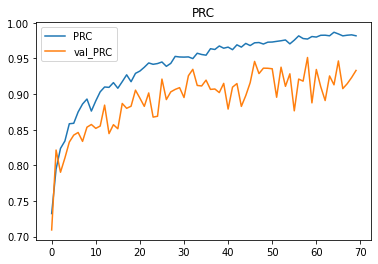

In [ ]:
plt.title('PRC')
plt.plot(xcresult_.history['prc'], label='PRC')
plt.plot(xcresult_.history['val_prc'], label='val_PRC')
plt.legend()

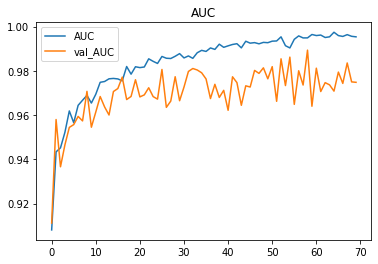

In [ ]:
plt.title('AUC')
plt.plot(xcresult_.history['auc'], label='AUC')
plt.plot(xcresult_.history['val_auc'], label='val_AUC')
plt.legend()

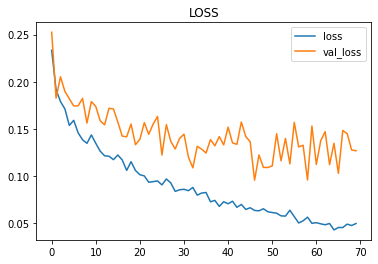

In [ ]:
plt.title('LOSS')
plt.plot(xcresult_.history['loss'], label='loss')
plt.plot(xcresult_.history['val_loss'], label='val_loss')
plt.legend()